In [1]:
using Distributions
using PyPlot

In [244]:
# squared exponential kernel type
# to store params
type SEKernel
    l2::Float64 # (length-scale)^2
    σ2::Float64 # function (std-dev)^2
    SEKernel(l::Float64,σ::Float64) = new(l^2,σ^2)
end

# kernel defintion for SE kernel
function kern(se::SEKernel, x::AbstractArray,x_::AbstractArray)
    diff = x - x_
    return se.σ2 * exp(-diff'*diff/(2se.l2))[1]
end

# dk/dx (not x_)
function d_kern(se::SEKernel, x::AbstractArray,x_::AbstractArray)
    diff = x - x_
    result =  -se.σ2 * diff * exp(-diff'*diff/(2se.l2))
    return result[1]
end

# d^2k/dx^2 (not x_)
function d2_kern(se::SEKernel, x::AbstractArray,x_::AbstractArray)
    diff = x - x_
    outer_product = diff*diff'
    result =  -(eye(outer_product) - outer_product)*se.σ2 * exp(-diff'*diff/(2se.l2))
    return result[1]
end

# create convariance matrix K
# X,X_ have rows of data points
function K(se::SEKernel, X::AbstractArray,X_::AbstractArray)
    K_ = zeros(size(X)[1], size(X_)[1])
    for i=1:size(K_)[1]
        for j=1:size(K_)[2]
            @inbounds K_[i,j] = kern(se, X[i,:], X_[j,:])
        end
    end
    return K_
end
function d_K(se::SEKernel, X::AbstractArray,X_::AbstractArray)
    K_ = zeros(size(X)[1], size(X_)[1])
    for i=1:size(K_)[1]
        for j=1:size(K_)[2]
            @inbounds K_[i,j] = -d_kern(se, X[i,:], X_[j,:])
        end
    end
    return K_
end
function d2_K(se::SEKernel, X::AbstractArray,X_::AbstractArray)
    K_ = zeros(size(X)[1], size(X_)[1])
    for i=1:size(K_)[1]
        for j=1:size(K_)[2]
            @inbounds K_[i,j] = d2_kern(se, X[i,:], X_[j,:])
        end
    end
    return K_
end

function K(se::SEKernel, x::Float64,x_::Float64)
    return kern(se, [x], [x_])
end

K (generic function with 2 methods)

__Algorithm 15.1:__ GP regression:
(Murphy pp. 526)
1. $L = \mathrm{cholesky}(K + \sigma_y^2 I)$
2. $\alpha = L^T \backslash (L \backslash y)$
3. $\mathbb{E}[f_*] = k_8^T\alpha$
4. $v = L \backslash k_*$
5. $\mathrm{var}[f_*] = \kappa(x_*,x_*) - v^Tv$
6. $\log p(y|X) = -\frac{1}{2}y^T\alpha - \sum_i \log L_{ii} - \frac{N}{2}\log(2\pi)$

In [242]:
σ = 2.
l = 0.75
se = SEKernel(l,σ)

# define some fake data

t = collect(0:0.5:10)
y_true = t.*sin(0.25*2π*t) + t
y = y_true + randn!(zeros(t))*2

# signal noise
σ_y = 1.5

println("==> Construct Kernels")
t_ = collect(-1:0.01:15)
K_ = K(se, t, t)
K_ = K_ + σ_y^2*eye(K_)

k_ = K(se, t, t_)
k__ = K(se, t_,t_)


println("==> Run GP Regression")
# GP Regression algorithm
# -- Machine Learning: A Probabalistic Perspective
#    Kevin Murphy, pp. 526
L = chol(K_)
α = L'\(L\y)
μ = k_'*α
v = L'\k_
σ = sqrt(diag(k__) - diag(v'*v))
logP = -y'*α/2 - sum(log(diag(L))) - size(y)[1]*log(2π)/2
println("--  done.")
println("==> Marginal Likelihood: log P(y|X) = $(logP[1])")

==> Construct Kernels
==> Run GP Regression
--  done.
==> Marginal Likelihood: log P(y|X) = -96.79092503992709


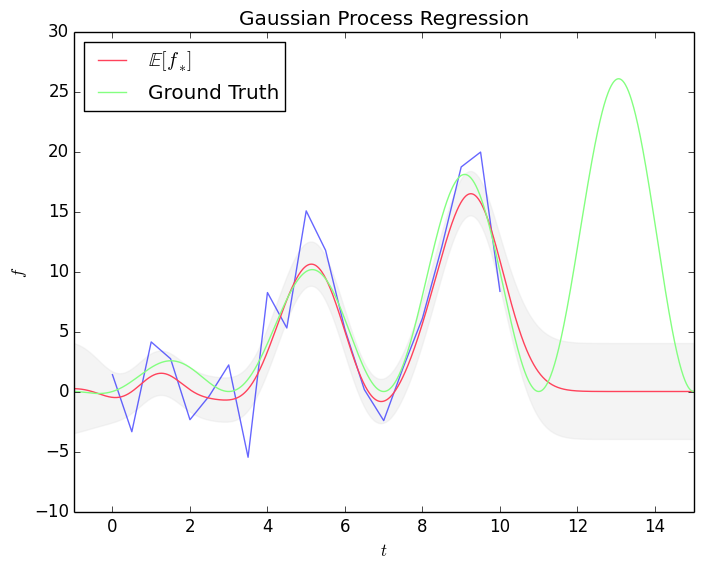

(-1,15)

In [65]:
plot(t,y, alpha=0.6) #label="\$f(t) = t\\sin(\\pi t/2) + t + \\epsilon\$", alpha=0.6)
plot(t_, μ, label="\$\\mathbb{E}[f_*]\$", color="#FF425B")
fill_between(t_, μ-2σ, μ+2σ, color="#dddddd", alpha=0.3)
plot(t_, t_.*sin(0.25*2π*t_) + t_, label="Ground Truth", color="#84FF80")
title("Gaussian Process Regression")
xlabel("\$t\$")
ylabel("\$f\$")
legend(loc="upper left")

xlim(-1,15)

(Murphy pp. 520)

Our Gaussian Process is given by the joint density

$$
    \begin{pmatrix}y\\f_* \end{pmatrix} \sim \mathcal{N}\left( 0, \begin{pmatrix} K_y & K_* \\ K_*^T & K_{**} \end{pmatrix} \right) 
$$

Note we assume the mean $\mu = 0$. Then our posterior predictive distribution is given by

$$
\begin{align*}
    p(f_*|x_*,X,y) &= \mathcal{N}(f_*|\mu_*,\Sigma_*)\\
    \mu &= K_*^TK_y^{-1}y\\
    \Sigma_* &= K_{**} - K_*^TK_y^{-1}K_*
\end{align*}
$$

When we have a single test input this becomes

$$
    p(f_*|x_*,X,y) = \mathcal{N}(f_*| k_*^TK_y^{-1}y,\; k_{**} - k_*^TK_y^{-1}k_*),
$$

where the posterior mean can be written

$$
    \overline f_* = k_*^TK_y^{-1}y = \sum_{i=1}^N \alpha_i \kappa(x_i, x_*)\qquad\alpha = K_y^{-1}y
$$

This gives the first derivative

$$
    \frac{\partial \overline f_*}{\partial x_*} = \sum_{i=1}^N \alpha_i \kappa'(x_i,x_*),
$$

For our Squared Exponential Kernel,

$$
    \kappa(x,x') = \sigma_f^2 \exp\left( -\frac{1}{2}(x-x')^T\Lambda^{-1}(x-x') \right) = \sigma_f^2 \exp\left( -\frac{1}{2}||x-x' ||_{\Lambda^{-1}}^2 \right).
$$

We have can differentiate this, as shown in ([Andrew McHutchon 2013](http://mlg.eng.cam.ac.uk/mchutchon/DifferentiatingGPs.pdf) pp. 6), giving

$$
\begin{align*}
    \frac{\partial \kappa(x,x')}{\partial x} &= -\sigma_f^2\Lambda^{-1}(x-x')\exp\left(-\frac{1}{2}||x-x'||_{\Lambda^{-1}}^2\right)\\
                                             &= -\Lambda^{-1}(x-x')\kappa(x,x')\\
    \frac{\partial^2 \kappa(x,x')}{\partial x^2} &= -\Lambda^{-1}\left(I - \Lambda^{-1}(x-x')(x-x')^T\right)\kappa(x,x')\\
    \frac{\partial^3 \kappa(x,x')}{\partial x^3} &= \\
\end{align*}
$$

==> Construct Kernels
==> Run GP Regression with Derivatives
--  done.
==> Marginal Likelihood: log P(y|X) = -82.44601079126437
==> Plot Results
==> dμ[10] = -0.24159329326174722 ≈ -0.4315147181239154


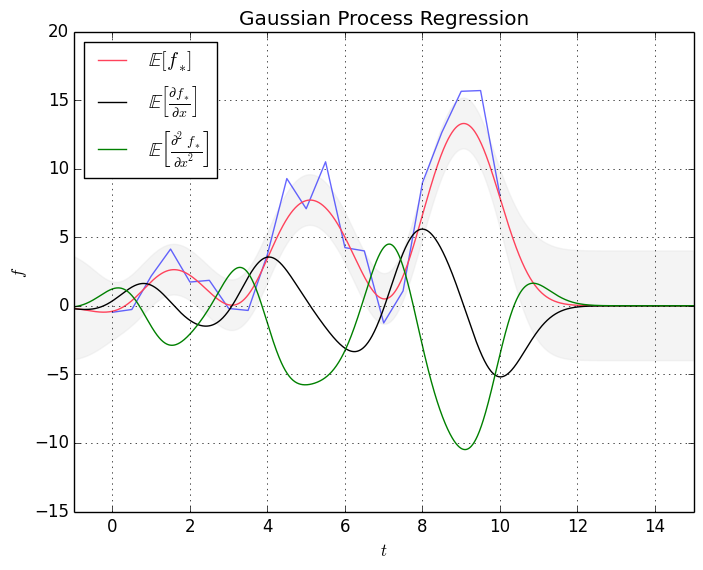

In [245]:
# define some fake data

t = collect(0:0.5:10)
y_true = t.*sin(0.25*2π*t) + t
y = y_true + randn!(zeros(t))*2

# signal noise
σ_y = 1.5

println("==> Construct Kernels")
σ = 2.
l = 0.75
se = SEKernel(l,σ)

t_ = collect(-1:0.01:15)
K_ = K(se, t, t)
K_ = K_ + σ_y^2*eye(K_)

k_ = K(se, t, t_)
dk_ = d_K(se,t,t_)
d2k_ = d2_K(se,t,t_)
k__ = K(se, t_,t_)


println("==> Run GP Regression with Derivatives")
# GP Regression algorithm + derivatives
# -- Machine Learning: A Probabalistic Perspective
#    Kevin Murphy, pp. 526
L = chol(K_)
α = L\(L'\y)
μ = k_'*α
dμ = dk_'*α
d2μ = d2k_'*α
v = L'\k_
σ = sqrt(diag(k__) - diag(v'*v))
logP = -y'*α/2 - sum(log(diag(L))) - size(y)[1]*log(2π)/2
println("--  done.")
println("==> Marginal Likelihood: log P(y|X) = $(logP[1])")

println("==> Plot Results")
plot(t,y, alpha=0.6)
plot(t_, μ, label="\$\\mathbb{E}[f_*]\$", color="#FF425B")
plot(t_, dμ, label="\$\\mathbb{E}\\left[\\frac{\\partial f_*}{\\partial x}\\right]\$", color="black")
plot(t_, d2μ, label="\$\\mathbb{E}\\left[\\frac{\\partial^2 f_*}{\\partial x^2}\\right]\$", color="green")
fill_between(t_, μ-2σ, μ+2σ, color="#dddddd", alpha=0.3)
#plot(t_, t_.*sin(0.25*2π*t_) + t_, label="Ground Truth", color="#84FF80")
title("Gaussian Process Regression")
xlabel("\$t\$")
ylabel("\$f\$")
legend(loc="upper left")

grid()

xlim(-1,15)

println("==> dμ[10] = $(dμ[10]) ≈ $((μ[11] - μ[10])/0.01)")

### Financial Data

In [36]:
using DataFrames

In [62]:
tsla_raw = readtable("../data/raw/financial/tsla.csv")

tsla_raw[:_Date] = Date(tsla_raw[:_Date],"d-u-y")

tsla_raw[:Date] = [Float64(datetime2rata(DateTime(date))) for date in tsla_raw[:_Date]]

sort!(tsla_raw, cols=[:Date])

head(tsla_raw)

,_Date,Open,High,Low,Close,Volume,Date
1,0015-05-05,237.76,239.5,229.13,232.95,5796873,5238.0
2,0015-05-06,234.1,234.47,228.2,230.43,5270933,5239.0
3,0015-05-07,221.0,237.48,220.25,236.8,9455909,5240.0
4,0015-05-08,235.99,238.41,233.7,236.61,4668236,5241.0
5,0015-05-11,236.29,242.88,235.31,239.49,5672262,5244.0
6,0015-05-12,240.11,246.35,238.19,244.74,6363429,5245.0


In [237]:
t    = collect(tsla_raw[:Date])
tsla = collect(tsla_raw[:Open])
tsla = (tsla - mean(tsla)) / std(tsla)
t_   = collect(minimum(t):0.25:maximum(t))

println("==> Run GP Regression over TSLA Open Prices")
println("--  between May 5, 2015 and May 4, 2016")

σ = 0.75
l = 30.
se = SEKernel(l,σ)
σ_y = 0.5

println("==> Construct Kernels")
K_ = K(se, t, t)
K_ = K_ + σ_y^2*eye(K_)

k_ = K(se, t, t_)
dk_ = d_K(se,t,t_)
d2k_ = d2_K(se,t,t_)
k__ = K(se, t_,t_)

println("--  done.")

==> Run GP Regression over TSLA Open Prices
--  between May 5, 2015 and May 4, 2016
==> Construct Kernels
--  done.


In [238]:
println("==> Run GP Regression with Derivatives")
# GP Regression algorithm + derivatives
# -- Machine Learning: A Probabalistic Perspective
#    Kevin Murphy, pp. 526
L = chol(K_)
α = L\(L'\tsla)
μ = k_'*α
dμ = dk_'*α
v = L'\k_
σ = sqrt(diag(k__) - diag(v'*v))
logP = -tsla'*α/2 - sum(log(diag(L))) - size(tsla)[1]*log(2π)/2
println("--  done.")
println("==> Marginal Likelihood: log P(y|X) = $(logP[1])")

==> Run GP Regression with Derivatives
--  done.
==> Marginal Likelihood: log P(y|X) = -131.61712190176354


### Note

Note that the derivative appears to not be scaled correctly, though the sign and critical points are accurate.

==> Plot Results


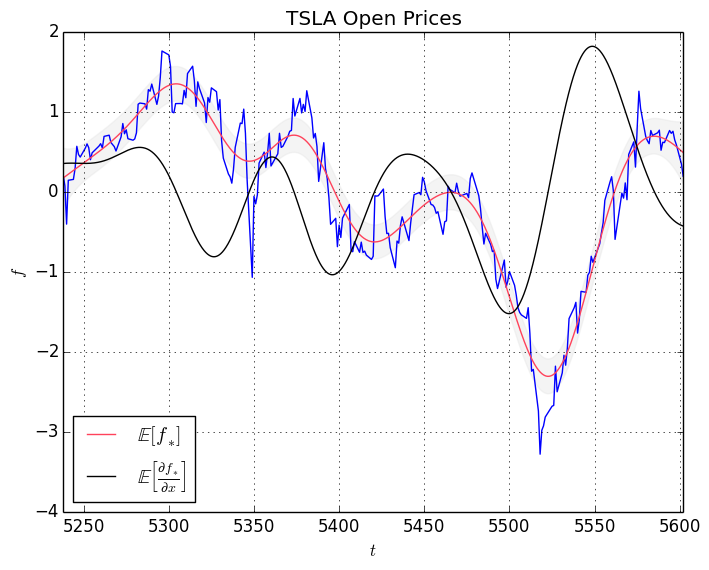

(5238.0,5602.0)

In [239]:
println("==> Plot Results")
plot(t,tsla)
plot(t_, μ, label="\$\\mathbb{E}[f_*]\$", color="#FF425B")
plot(t_, dμ/40, label="\$\\mathbb{E}\\left[\\frac{\\partial f_*}{\\partial x}\\right]\$", color="black")
fill_between(t_, μ-2σ, μ+2σ, color="#dddddd", alpha=0.3)
title("TSLA Open Prices")
xlabel("\$t\$")
ylabel("\$f\$")
legend(loc="lower left")

grid()
xlim(minimum(t), maximum(t))